In [22]:
'''  Import and common functions  '''
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem,Draw
from rdkit.Chem import MCS
import rdkit
rdkit.RDLogger.DisableLog('rdApp.*')
lg = rdkit.RDLogger.logger()
lg.setLevel(rdkit.RDLogger.CRITICAL)

import pandas as pd
import numpy as np
import copy,re
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol,MakeScaffoldGeneric,MurckoScaffoldSmiles,MurckoScaffoldSmilesFromSmiles
from my_toolset.my_utils import get_mol,compute_FP,canonic_smiles,mapper,weight
from my_toolset.drawing_utils import show_mols
import os,sys
from utils.common_utils import mapper,csvToExcel,get_mol,compute_FP,canonic_smiles,float_row,heavy_atm_smiles,kekulize_smi,sort_mol_sim_df
from utils.sarm_utils import get_core,get_complete_frag,connect2Frags

from IPython.display import display, SVG, display_svg
import seaborn as sns
from matplotlib import pyplot
from pathlib import Path
import glob
from functools import partial
from pandarallel import pandarallel
from rdkit.Chem.MolStandardize import rdMolStandardize 
n_jobs=40
pandarallel.initialize(nb_workers=n_jobs)

import math
import itertools
import matplotlib.pyplot as plt
import plotly.express as px
import json
import openpyxl
from openpyxl.drawing.image import Image 
from openpyxl.drawing.spreadsheet_drawing import AnchorMarker
from collections import defaultdict
from rdkit.Chem.Draw import MolDraw2DCairo

def match(smiles,smarts):
    mol=get_mol(smiles)
    smartsMol=Chem.MolFromSmarts(smarts)
    matched=mol.GetSubstructMatches(smartsMol)
    if len(matched)>0:
        return 1
    else:
        return 0
    
def motif_addR(motif1, actSdfs):
    completeMotifs_list=[]
    for isdf in actSdfs:
        try:
            suppl = Chem.SDMolSupplier(isdf)
            mol=suppl[0]
            molNumAtoms=mol.GetNumAtoms()
            if molNumAtoms>150:
                continue
            fragWithR=get_complete_frag(mol,motif1)
            for ifrag in fragWithR:
                if match(ifrag,motif1): ## to fix a bug some fragments doesn't match query
                    completeMotifs_list.append([motif1,ifrag])
        except Exception as e:
            continue
    completeMotifs_list=[tuple(imotif) for imotif in completeMotifs_list] ## set cannot handle list so transform list to tuple
    completeMotifs_list=set(completeMotifs_list)
    completeMotifs_list=[list(imotif) for imotif in completeMotifs_list]
    return completeMotifs_list

def uncharge(smi):
    mol=get_mol(smi)
    un = rdMolStandardize.Uncharger() 
    mol=un.uncharge(mol) 
    smi=Chem.MolToSmiles(mol)
    return smi

def replace_nH(ismarts):
    ismarts=ismarts.replace('[nH]','n')
    ismarts=ismarts.replace('-','')
    return ismarts

def match_frag(ismi,ismarts):
    # print("ismi",ismi)
    # print("ismarts",ismarts)
    mol = Chem.MolFromSmiles(ismi)
    ismarts=replace_nH(ismarts)
    smartsMol = Chem.MolFromSmarts(ismarts) #,sanitize=False
    matched=mol.GetSubstructMatches(smartsMol)
    if len(matched)>0:
        # print(matched)
        return 1
    else:
        return 0

def remove_dummy(smi):
    FragMol=Chem.MolFromSmiles(smi)
    matched=FragMol.GetSubstructMatches(Chem.MolFromSmarts("[#7][#0]"))
    atoms=FragMol.GetAtoms()
    for imatch in matched:
        atoms[imatch[1]].SetAtomicNum(1)
    # imol.UpdatePropertyCache()
    Chem.SanitizeMol(FragMol)
    FragMol=Chem.RemoveHs(FragMol)
    smi=Chem.MolToSmiles(FragMol)
    re_p=re.compile(r'\(\*\)|\*|\[\*\]|\-')
    ifrag_nodummy = re.sub(re_p, '', smi)  ## remove dummy atoms
    return ifrag_nodummy

def get_atomRingInfo(smi):
    mol=get_mol(smi)
    rInfo=mol.GetRingInfo()
    atomRingInfo=np.zeros(mol.GetNumAtoms())
    for iring in rInfo.AtomRings():
        iring=list(iring)
        atomRingInfo[iring]+=1
    return atomRingInfo

def match_core(ismi,ismarts):
    # print("ismi",ismi)
    # print("ismarts",ismarts)
    # mol = Chem.MolFromSmiles(ismi)
    mol=get_mol(ismi)
    # ismarts=replace_nH(ismarts)
    if '*' in ismarts:
        ismartsNodummy=remove_dummy(ismarts)
    else:
        ismartsNodummy=ismarts
    smartsMol = Chem.MolFromSmarts(ismartsNodummy) #,sanitize=False
    matched=mol.GetSubstructMatches(smartsMol)
    if len(matched)>0:
        smartRI=get_atomRingInfo(ismartsNodummy)
        # print(f"smartRI= {smartRI}")
        molRI=get_atomRingInfo(mol)
        for imatch in matched:
            submolRI=molRI[list(imatch)]
            # print(f"submolRI= {submolRI}")
            diff=np.absolute(smartRI-submolRI).sum()
            # print(matched)
            if diff==0:
                return 1
        return 0
    else:
        return 0

def get_activity_info(df_act, frag, cols):
    df_act=df_act.copy()
    df_act['matched']=df_act.apply(lambda x: match_core(x['Cano_SMILES'],ismarts=frag),axis=1)
    df_match=df_act[df_act['matched']==1]
    # print(df_match)
    if len(df_match)==0:
        return '',0
    if len(df_match)==1:
        means=df_match.iloc[0]
        stds=df_match.iloc[0]
        medians=df_match.iloc[0]
    if len(df_match)>1:
        means=df_match.mean()
        stds=df_match.std()
        medians=df_match.median()
    actInfo=''
    for itarget in cols:
        iInfo='{0: <8}'.format(f"{itarget}:")
        for imetric in [means,stds,medians]:
            iInfo+='{0: <8}'.format(f"{round(imetric[itarget],1)}")
        iInfo+="|\n"
        actInfo+=iInfo
    return actInfo

def show_mols_cairo(ismi,legend,special=0):
    mol = Chem.MolFromSmiles(ismi)
    drawer = MolDraw2DCairo(400, 200)
    drawer.drawOptions().legendFontSize = 40
    if special:
        colors = [(0.9019607843137255, 0.6235294117647059, 0.0), 
          (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
         (0.0, 0.6196078431372549, 0.45098039215686275)]
        highlightatoms = defaultdict(list)
        highlightbonds = defaultdict(list)
        atomrads = {}
        for iatom in mol.GetAtoms():
            iatomIdx=iatom.GetIdx()
            highlightatoms[iatomIdx].append(colors[1])
            atomrads[iatomIdx] = 1
        drawer.DrawMoleculeWithHighlights(mol,legend,dict(highlightatoms),dict(highlightbonds),atomrads,{}) #,dict(highlightatoms),dict(highlightbonds)
    else:
        drawer.DrawMolecule(mol,legend=legend)
    drawer.FinishDrawing()
    img = drawer.GetDrawingText()
    # with open('mol.png', 'wb') as f:
    #     f.write(img)
    return img

def show_cpd(img_icpd,df_act,cols):
    imgPath=img_icpd[0]
    icpd=img_icpd[1]
    if icpd=='':
        return None
    actInfo=get_activity_info(df_act,icpd,cols)
    img=show_mols_cairo(icpd, actInfo)   ## Do not colour the compounds
    with open(imgPath, 'wb') as f:
        f.write(img)
    return [imgPath,icpd]

def csvToExcel(csv, imgCols=['SMILES'], targets=['AMPK'], save_file='', max_imgs=500, column=False, AMPK_actFile='',JAK_actFile=''):
    '''  Transform Pandas dataframe into Excel  '''
    df_actAMPK=pd.read_csv(AMPK_actFile)
    df_actAMPK=df_actAMPK.dropna(subset=["EC50nM"])
    df_actAMPK["Cano_SMILES"]=df_actAMPK["SMILES"].parallel_apply(canonic_smiles)
    df_actJAK=pd.read_csv(JAK_actFile)
    df_actJAK=df_actJAK.dropna(subset=["JAK1"])
    df_actJAK["Cano_SMILES"]=df_actJAK["SMILES"].parallel_apply(canonic_smiles)
    
    df=pd.read_csv(csv)
    LETTERS = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'  ## the maximum columns cannot too long
    wb = openpyxl.Workbook()
    # ws = wb.create_sheet('Sheet1')
    ws = wb.active
    tmpImgPath=Path('./images_excel_png')
    tmpImgPath.mkdir(exist_ok=True, parents=True)
    col_names=df.columns.to_list()
    ###  Write column head
    for icol,val in enumerate(col_names):
        irow=1
        if column:
            try:
            # if 1:  ## for dubugging
                col_letter=LETTERS[icol]
                ws.row_dimensions[irow].height = 90
                ws.column_dimensions[col_letter].width = 20
                mol = Chem.MolFromSmiles(val)
                img = Draw.MolToImage(mol, size=[200, 200])
                img.save(tmpImgPath.joinpath(f'molecule{irow}{icol}.png'))
                img=Image(tmpImgPath.joinpath(f'molecule{irow}{icol}.png'))
                img.width = 100
                img.height = 100
                # print(ws.cell(row=irow, column=icol).coordinate)
                img.anchor = ws.cell(row=irow, column=icol+1).coordinate # col and row are zero-based
                # ws.add_image(img, f"{col_letter}{irow}")
                ws.add_image(img)
            except Exception as e:
                print(e)
                continue
        ws.cell(irow,icol+1).value=val
    for idx,row in df.iterrows():
        irow=idx+2 ## the row id start from one and the first was occupied by head
        for icol,vcol in enumerate(col_names):
            if vcol in imgCols and targets[imgCols.index(vcol)]=="AMPK":
                if icol>max_imgs:
                    continue
                try:
                # if 1:  ## for dubugging
                    col_letter=LETTERS[icol]
                    ws.row_dimensions[irow].height = 90
                    ws.column_dimensions[col_letter].width = 25
                    # mol = Chem.MolFromSmiles(row[vcol])
                    img_icpd=[tmpImgPath.joinpath(f'molecule{irow}{icol}.png'), row[vcol]]
                    imgPath_icpd=show_cpd(img_icpd, df_act=df_actAMPK, cols=['EC50nM'])
                    # img = Draw.MolToImage(mol, size=[400, 200])
                    # img.save(tmpImgPath.joinpath(f'molecule{irow}{icol}.png'))
                    img=Image(tmpImgPath.joinpath(f'molecule{irow}{icol}.png'))
                    img.width = 200
                    img.height = 100
                    # print(ws.cell(row=irow, column=icol).coordinate)
                    img.anchor = ws.cell(row=irow, column=icol+1).coordinate # col and row are zero-based
                    # ws.add_image(img, f"{col_letter}{irow}")
                    ws.add_image(img)
                except Exception as e:
                    print(e)
                    continue
                
            if vcol in imgCols and targets[imgCols.index(vcol)]=="JAK":
                if icol>max_imgs:
                    continue
                try:
                # if 1:  ## for dubugging
                    col_letter=LETTERS[icol]
                    ws.row_dimensions[irow].height = 90
                    ws.column_dimensions[col_letter].width = 25
                    # mol = Chem.MolFromSmiles(row[vcol])
                    img_icpd=[tmpImgPath.joinpath(f'molecule{irow}{icol}.png'), row[vcol]]
                    imgPath_icpd=show_cpd(img_icpd, df_act=df_actJAK, cols=['JAK1'])
                    # img = Draw.MolToImage(mol, size=[400, 200])
                    # img.save(tmpImgPath.joinpath(f'molecule{irow}{icol}.png'))
                    img=Image(tmpImgPath.joinpath(f'molecule{irow}{icol}.png'))
                    img.width = 200
                    img.height = 100
                    # print(ws.cell(row=irow, column=icol).coordinate)
                    img.anchor = ws.cell(row=irow, column=icol+1).coordinate # col and row are zero-based
                    # ws.add_image(img, f"{col_letter}{irow}")
                    ws.add_image(img)
                except Exception as e:
                    print(e)
                    continue
            
            if vcol in imgCols and targets[imgCols.index(vcol)]=="":
                if icol>max_imgs:
                    continue
                try:
                # if 1:  ## for dubugging
                    col_letter=LETTERS[icol]
                    ws.row_dimensions[irow].height = 90
                    ws.column_dimensions[col_letter].width = 25
                    mol = Chem.MolFromSmiles(row[vcol])
                    # img_icpd=[tmpImgPath.joinpath(f'molecule{irow}{icol}.png'), row[vcol]]
                    # imgPath_icpd=show_cpd(img_icpd, df_act=df_actAMPK, cols=['EC50nM'])
                    img = Draw.MolToImage(mol, size=[400, 200])
                    img.save(tmpImgPath.joinpath(f'molecule{irow}{icol}.png'))
                    img=Image(tmpImgPath.joinpath(f'molecule{irow}{icol}.png'))
                    img.width = 200
                    img.height = 100
                    # print(ws.cell(row=irow, column=icol).coordinate)
                    img.anchor = ws.cell(row=irow, column=icol+1).coordinate # col and row are zero-based
                    # ws.add_image(img, f"{col_letter}{irow}")
                    ws.add_image(img)
                except Exception as e:
                    print(e)
                    continue
                
            ws.cell(irow,icol+1).value=row[vcol]  ## add value to the folders
    wb.save(save_file)
    wb.close()
    os.system(f"rm -rf {tmpImgPath}")
    return wb



INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [23]:
###  JAK&AMPK csv to Excel with activity information
JAK_ActFile="/public/home/zhangjie/Projects/autosarm/JAK1JAK2_Selectivity/Data/JAK_All_Mar22_PK.csv"
AMPK_ActFile="/public/home/zhangjie/Projects/autosarm/AMPK_Activity/Data/Active_cpds_PRKAB1_cano.csv"
# csvToExcel("/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/AMPK_CombTable_Round1_actInfo_poseScore.csv", imgCols=['SMILES','noDumSmi'], targets=['AMPK',''], save_file="/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/AMPK_CombTable_Round1_actInfo_poseScore.xlsx", max_imgs=500, column=False, AMPK_actFile=AMPK_ActFile, JAK_actFile=JAK_ActFile)

csvToExcel("/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/JAK1_CombTable_Round1_actInfo_poseScore.csv", imgCols=['SMILES','noDumSmi'], targets=['JAK',''], save_file="/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/JAK1_CombTable_Round1_actInfo_poseScore.xlsx", max_imgs=500, column=False, AMPK_actFile=AMPK_ActFile, JAK_actFile=JAK_ActFile)



Python argument types in
    MolDraw2D.DrawMolecule(MolDraw2DCairo, Mol)
did not match C++ signature:
    DrawMolecule(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, boost::python::api::object highlightAtoms, boost::python::api::object highlightBonds, boost::python::api::object highlightAtomColors=None, boost::python::api::object highlightBondColors=None, boost::python::api::object highlightAtomRadii=None, int confId=-1, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > legend='')
    DrawMolecule(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, boost::python::api::object highlightAtoms=None, boost::python::api::object highlightAtomColors=None, boost::python::api::object highlightAtomRadii=None, int confId=-1, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > legend='')
Python argument types in
    MolDraw2D.DrawMolecule(MolDraw2DCairo, Mol)
did not match C++ signature:
    DrawMolecule(RDKit::MolDraw2D {lvalue} self, RDKi

In [26]:
'''  Connect motifs from both targets and design molecules  '''
ifGetCompleteFrag=0
ifLinkMotif=0


'''  Configure section  '''
motifJAK_csvFile="/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/JAK1_CombTable_Round1_actInfo_poseScore.csv"
motifAMPK_csvFile="/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/AMPK_CombTable_Round1_actInfo_poseScore.csv"

actJAK_sdfFolder="/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/JAK_Act_Dock/sdfs"
actAMPK_sdfFolder="/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/AMPK_Act_Dock/sdfs"

if ifGetCompleteFrag:
    df_motifJAK=pd.read_csv(motifJAK_csvFile)
    df_motifJAK=df_motifJAK[df_motifJAK['SeleEnum']==1]  ## Select the motif for enumeration
    df_motifAMPK=pd.read_csv(motifAMPK_csvFile)
    df_motifAMPK=df_motifAMPK[df_motifAMPK['SeleEnum']==1]
    print(f"Number of JAK motifs for enumeration: {len(df_motifJAK)}")
    print(f"Number of AMPK motifs for enumeration: {len(df_motifAMPK)}")

    actJAK_sdfs=glob.glob(f"{actJAK_sdfFolder}/*.sdf") 
    actAMPK_sdfs=glob.glob(f"{actAMPK_sdfFolder}/*.sdf") 
    ## Fetch complte AMPK motifs 
    motif_addR_p=partial(motif_addR, actSdfs=actAMPK_sdfs)
    completeMotifs_AMPK=mapper(40)(motif_addR_p,df_motifAMPK['SMILES']) ## two dimensional
    completeMotifs_AMPK = [item for sublist in completeMotifs_AMPK for item in sublist]
    print(f"Number of complete AMPK motifs for enumeration: {len(completeMotifs_AMPK)}")
    ## Fetch complte JAK motifs 
    motif_addR_p=partial(motif_addR, actSdfs=actJAK_sdfs)
    completeMotifs_JAK=mapper(40)(motif_addR_p,df_motifJAK['SMILES']) ## two dimensional
    completeMotifs_JAK = [item for sublist in completeMotifs_JAK for item in sublist]
    print(f"Number of complete AMPK motifs for enumeration: {len(completeMotifs_JAK)}")

if ifLinkMotif:
    genCPDs_list=[]
    for imotif_AMPK in completeMotifs_AMPK:
        for imotif_JAK in completeMotifs_JAK:
            linkSmi=connect2Frags(imotif_AMPK[1],imotif_JAK[1])
            genCPDs_list.append([imotif_AMPK[0],imotif_JAK[0],imotif_AMPK[1],imotif_JAK[1],linkSmi])  ## [AMPK_scaffold,JAK_scaffold,AMPK_completeMotif,JAK_completeMotif,MoleculeGenerated]
    
    df_genCPD=pd.DataFrame(genCPDs_list, columns=['AMPK_scaffold','JAK_scaffold','AMPK_Frag','JAK_Frag','SMILES'])
    df_genCPD['Wt']=df_genCPD['SMILES'].parallel_apply(weight)
    df_genCPD.to_csv("/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/GenCPDs/GenCPDs_all.csv",index=None)


Number of CPDs with Wt<600: 12206
Calculating QED!
Calculating Weight!
Calculating LogP!
Total compounds in the file:  12206
Compounds pass the filters:  11348
Number of CPDs passed filter with Wt<600 : 11348


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


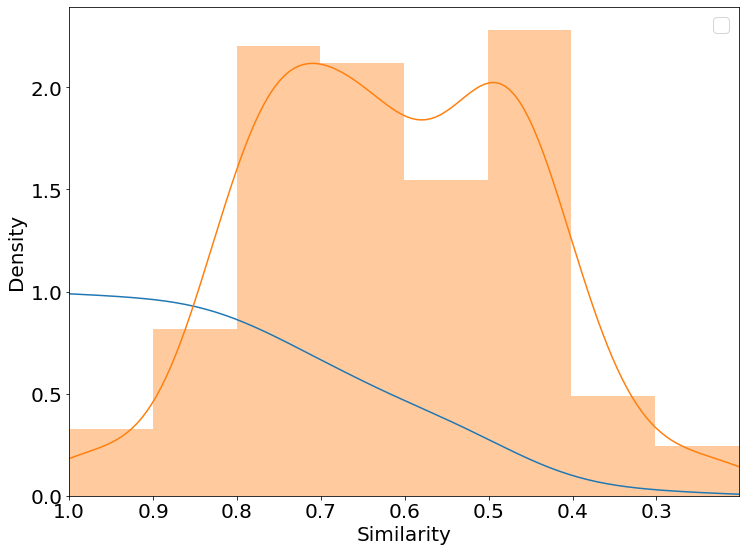

In [2]:
ifWt_plot=0
ifPlotMedChemWt=0
ifMedSim_plot=0
ifSmaller_plot=1

file_gen="/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/GenCPDs/GenCPDs_all.csv"
df_genCPD=pd.read_csv(file_gen)
df_genCPD=df_genCPD[df_genCPD['Wt']<600]
df_genCPD.to_csv("/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/GenCPDs/GenCPDs_WtLt600.csv",index=None)
print(f"Number of CPDs with Wt<600: {len(df_genCPD)}")
os.system(f"python /public/home/zhangjie/Projects/REINVENT-master/filter_pains.py --csv_file /public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/GenCPDs/GenCPDs_WtLt600.csv  --op_file  /public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/GenCPDs/GenCPDs_WtLt600_pains.csv  --n_jobs 60")
df_genCPD=pd.read_csv("/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/GenCPDs/GenCPDs_WtLt600_pains.csv")
df_genCPD=df_genCPD[df_genCPD['Pass_filter']==1]
# df_genCPD["SMILES"]=df_genCPD["SMILES"].apply(uncharge)
print(f"Number of CPDs passed filter with Wt<600 : {len(df_genCPD)}")
df_genCPD=pd.DataFrame(df_genCPD)

if ifWt_plot:
    fig = plt.figure(figsize=(12, 9))
    plt.rcParams.update({'font.size': 20}) 
    sns.distplot(df_genCPD['Wt'],label='distribution')
    ax2=plt.twinx()
    sns.distplot(df_genCPD['Wt'],hist=False, kde_kws={"cumulative": True},ax=ax2,color='brown',label='cumulative')
    plt.legend()
    # plt.xlim(0,100)
    plt.xlabel("Wt")
    plt.ylabel("Density") 
    plt.show() 
    
def compute_sim(smi1, ref_smi):
    mol1 = get_mol(smi1)
    FP1 = AllChem.GetMorganFingerprintAsBitVect(
    mol1, 2, nBits=1024)
    mol2 = get_mol(ref_smi)
    FP2 = AllChem.GetMorganFingerprintAsBitVect(
    mol2, 2, nBits=1024)
    molSim = DataStructs.TanimotoSimilarity(
                FP1, FP2) 
    smi1=Chem.MolToSmiles(mol1)
    return [smi1, molSim]

if ifMedSim_plot:
    calSim=0
    if calSim:
        dfMedChem=pd.read_csv("/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/MEDCHEM/AIXB-3-AI-MED-IC50_20230324.csv")
        dfMedChem['Wt']=dfMedChem['SMILES'].apply(weight)
        if ifPlotMedChemWt:
            '''  Plot weight distribution of MedChem  '''
            fig = plt.figure(figsize=(12, 9))
            plt.rcParams.update({'font.size': 20})
            sns.distplot(dfMedChem['Wt'])
            plt.legend()
            # plt.xlim(0,100)
            plt.xlabel("Wt")
            plt.ylabel("Density") 
            plt.legend()
            plt.show() 
        
        dfMedChem.set_index('title',drop=False,inplace=True)
        dfTmp=dfMedChem.copy()
        for idx,irow in dfTmp.iterrows():
            refSmi=irow['SMILES']
            compute_sim_p=partial(compute_sim, ref_smi=refSmi)
            simList=mapper(50)(compute_sim_p, df_genCPD['SMILES'])
            dfSim=pd.DataFrame(simList,columns=['SMILES','sim'])
            dfSim.sort_values(by="sim", ascending=False, inplace=True)
            dfSim.reset_index(drop=True, inplace=True)
            dfMedChem.loc[idx,['MedChemSMILES','Similarity']]=[dfSim['SMILES'][0],dfSim['sim'][0]]
        dfMedChem.to_csv("/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/GenCPDs/GenCPDs_all_MedChemMaxSim.csv",index=None)
    dfMedChem=pd.read_csv("/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/GenCPDs/GenCPDs_all_MedChemMaxSim.csv")
    fig = plt.figure(figsize=(12, 9))
    plt.rcParams.update({'font.size': 20})
    sns.distplot(dfMedChem['Similarity'],hist=False, kde_kws={"cumulative": True})
    sns.distplot(dfMedChem['Similarity'])
    plt.legend()
    # plt.xlim(0,100)
    plt.xlabel("Similarity")
    plt.ylabel("Density") 
    plt.xlim(max(dfMedChem['Similarity']), min(dfMedChem['Similarity']))
    plt.show() 
 
if ifSmaller_plot:
    df_genCPD['AMPK-Wt']=df_genCPD['AMPK_Frag'].parallel_apply(weight)
    df_genCPD['JAK-Wt']=df_genCPD['JAK_Frag'].parallel_apply(weight)
    if 0: #plot JAK frag weight versus AMPK frag weight
        fig = plt.figure(figsize=(12, 9))
        plt.rcParams.update({'font.size': 20})
        # sns.scatterplot(data=df_genCPD, x='AMPK-Wt', y="JAK-Wt")
        sns.jointplot(data=df_genCPD, x='AMPK-Wt', y="JAK-Wt", kind='kde', cmap='hot_r', n_levels=60, fill=True)
        plt.legend()
        # plt.xlim(0,100)
        plt.xlabel("AMPK Frag. Wt")
        plt.ylabel("JAK Frag. Wt") 
        plt.show()
    df_genCPD_group = df_genCPD.groupby(["AMPK_scaffold", "JAK_scaffold"],as_index=False,group_keys=True).agg({'AMPK-Wt': "min", 'JAK-Wt': "min"})
    df_genCPD_group.set_index(["AMPK_scaffold", "JAK_scaffold"],drop=False,inplace=True)
    df_genCPD.drop_duplicates(subset=["AMPK_scaffold", "JAK_scaffold","AMPK-Wt", "JAK-Wt"],inplace=True)
    for idx,irow in df_genCPD.iterrows():
        itmGenCPD=df_genCPD_group.loc[(irow["AMPK_scaffold"],irow["JAK_scaffold"])]
        df_genCPD.loc[idx,'WtDiff']=abs(itmGenCPD['AMPK-Wt']-irow['AMPK-Wt'])+abs(itmGenCPD['JAK-Wt']-irow['JAK-Wt'])
    df_genCPD=df_genCPD[df_genCPD['WtDiff']<1E-3]
    
    df_genCPD["SMILES"]=df_genCPD["SMILES"].apply(uncharge)
    df_genCPD.to_csv("/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/GenCPDs/GenCPDs_Round1_1K.csv",index=None)
    df_genCPD_min=pd.read_csv("/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/GenCPDs/GenCPDs_Round1_1K.csv")
    calSim=1  ### Calculate the similarity between generated and MedChem designed CPDs
    if calSim:
        dfMedChem=pd.read_csv("/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/MEDCHEM/AIXB-3-AI-MED-IC50_20230324.csv")
        dfMedChem['Wt']=dfMedChem['SMILES'].apply(weight)
        if ifPlotMedChemWt:
            '''  Plot weight distribution of MedChem  '''
            fig = plt.figure(figsize=(12, 9))
            plt.rcParams.update({'font.size': 20})
            sns.distplot(dfMedChem['Wt'])
            plt.legend()
            # plt.xlim(0,100)
            plt.xlabel("Wt")
            plt.ylabel("Density") 
            plt.legend()
            plt.show() 
        
        dfMedChem.set_index('title',drop=False,inplace=True)
        dfTmp=dfMedChem.copy()
        for idx,irow in dfTmp.iterrows():
            refSmi=irow['SMILES']
            compute_sim_p=partial(compute_sim, ref_smi=refSmi)
            simList=mapper(50)(compute_sim_p, df_genCPD_min['SMILES'])
            dfSim=pd.DataFrame(simList,columns=['SMILES','sim'])
            dfSim.sort_values(by="sim", ascending=False, inplace=True)
            dfSim.reset_index(drop=True, inplace=True)
            dfMedChem.loc[idx,['MedChemSMILES','Similarity']]=[dfSim['SMILES'][0],dfSim['sim'][0]]
        dfMedChem.to_csv("/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/GenCPDs/GenCPDs_Round1_1K_MedChemMaxSim.csv")
        
        # dfMedChem=pd.read_csv("/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/GenCPDs/GenCPDs_Round1_1K_MedChemMaxSim.csv")
        fig = plt.figure(figsize=(12, 9))
        plt.rcParams.update({'font.size': 20})
        sns.distplot(dfMedChem['Similarity'],hist=False, kde_kws={"cumulative": True})
        sns.distplot(dfMedChem['Similarity'])
        plt.legend()
        # plt.xlim(0,100)
        plt.xlabel("Similarity")
        plt.ylabel("Density") 
        plt.xlim(max(dfMedChem['Similarity']), min(dfMedChem['Similarity']))
        plt.show() 
        